# Installing Libs

In [1]:
%%writefile requirements.txt

ts_train
tsaug

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

# Loading Libs

In [3]:
%load_ext autoreload
%autoreload 2

import time
import sys
import io
import joblib
import warnings
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import models # Sequential
from tensorflow.keras import layers  # LSTM, Masking, RepeatVector, TimeDistributed, Dense, Bidirectional, Masking, Conv1D, MaxPool1D, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras import optimizers # Adam
from tensorflow.keras.utils import plot_model, Sequence, to_categorical
from tensorflow.keras import callbacks # import LambdaCallback, EarlyStopping, TensorBoard, ModelCheckpoint, Callback, LearningRateScheduler, ReduceLROnPlateau

import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
import cv2

import sys
import ts_train
import tsaug

warnings.filterwarnings('ignore')

Num GPUs Available:  1


In [4]:
# Training PARAMS
N_EPOCHS = 1300 #
TRAIN_SECS = 60*60*1 # 1 hr
BATCH_SIZE = 128 # 

# Data Preprocessing
target_len=60
xup=5
start_pad=10

CMAP = 'magma'

# # Sample Selection
# train_index = [0,1,2,3,4,
#                9,11,12,13]
# train_index = [0,3,4,5,6,
#                9,11,15,18,
#                23, 26, 28, 30,
#                33, 35, 36]

In [5]:
class TimedStopping(callbacks.Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        safety_factor: stop safety_factor * average_time_per_epoch earlier
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, safety_factor=1, verbose=0):
        super(callbacks.Callback, self).__init__()

        self.start_time = 0
        self.safety_factor = safety_factor
        self.seconds = seconds
        self.verbose = verbose
        self.time_logs = []

    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        elapsed_time = time.time() - self.start_time
        self.time_logs.append(elapsed_time)

        avg_elapsed_time = float(sum(self.time_logs)) / \
            max(len(self.time_logs), 1)

        print(" ", self.seconds - self.safety_factor * avg_elapsed_time)
        if elapsed_time > self.seconds - self.safety_factor * avg_elapsed_time:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)

# Load Data

In [6]:
# samples_anno_df = pd.read_pickle("/kaggle/input/samples_anno_df.joblib")
samples_anno_df = joblib.load("/kaggle/input/tsmodeler/samples_anno_df.joblib")
samples_anno_df["fetch_lenght"] = samples_anno_df["signal"].apply(lambda x: x[0].shape[0])

print(samples_anno_df.shape)
samples_anno_df[:3]

(1000, 3)


,class_id,signal,fetch_lenght
606,19,"[[4.69, 4.61, 4.59, 963.49, 1485.48, 1480.42, ...",40
2338,10,"[[4.7, 4.78, 4.85, 1523.97, 1522.2, 1512.92, 1...",45
2508,8,"[[4.89, 4.95, 4.99, 142.85, 96.95, 94.83, 92.7...",87


In [7]:
samples_anno_df.class_id.value_counts()

18    85
10    71
0     67
19    61
8     60
11    58
15    57
4     57
9     57
17    55
13    53
16    51
3     51
12    49
1     48
2     43
5     38
7     20
6     19
Name: class_id, dtype: int64

In [ ]:
sequence = samples_anno_df["signal"].iloc[2][0]
# sequence = sequence/sequence.sum()
sequence.plot(style=".:")
sequence.shape

In [9]:
# STFT Settings
samplerate = 5 # eg.
nperseg  = 0.5 * samplerate # Window Size
noverlap = nperseg*0.95 # Overlap
nfft     = 1 * samplerate # STFT
window   = 'hann' # Window Type

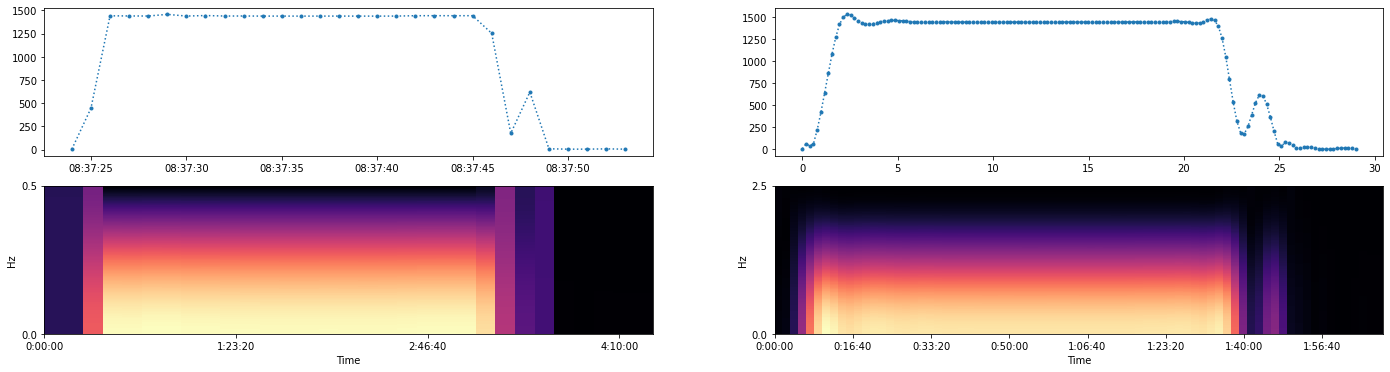

In [10]:

sample_idx = np.random.randint(1000)
sequence = samples_anno_df["signal"].iloc[sample_idx][0]

_sr = sequence
arr = np.abs(ts_train.data.interpolate_series(_sr.reset_index(drop=True), _sr.shape[0]*xup, method='spline'))

fig, ax = plt.subplots(2, 2, figsize=(24, 6))

axi = ax[0,0]
axi.plot(_sr,".:")

axi = ax[1,0]
stft = librosa.stft(_sr.values,
                    n_fft=512,
                    hop_length=1,
                    win_length=3,
                    window='hann',
                    center=True,)
librosa.display.specshow(stft, x_axis='time', y_axis='log', sr=1, ax=axi)

axi = ax[0,1]
axi.plot(arr,".:")

axi = ax[1,1]
stft = librosa.stft(arr.values,
                    n_fft=512,
                    hop_length=2, # 2
                    win_length=4, # 3
                    window='hann',
                    center=True,)
librosa.display.specshow(stft, x_axis='time', y_axis='log', sr=5, ax=axi)
plt.show()


In [11]:
stft.shape

(257, 76)

In [12]:
def calc_stft(arr, xupsample=None, resize=None):
    # print("arr", len(arr))
    
    if xupsample:
        _sr = pd.Series(arr)
        _srx = np.abs(ts_train.data.interpolate_series(_sr.reset_index(drop=True), _sr.shape[0]*xupsample, method='spline'))
    
    stft = librosa.stft(
            _srx.values,
            n_fft=512,
            hop_length=2, # 2
            win_length=4, # 3
            window='hann',
            center=True)
    
    if resize:
        stft_img = img_resize(stft, resize, resize, log=False, lthres=0)
        return stft_img
    
    return stft
    
def img_resize(cs, w=512, h=512, log=True, lthres=-30):
    buf = io.BytesIO()
    if log == True:
        plt.imsave(buf, 20*np.log10(np.abs(cs)), cmap=CMAP, format='png', vmax=0, vmin=lthres)
    else:
        plt.imsave(buf, np.abs(cs), cmap=CMAP, format='png')
    buf.seek(0)
    img_bytes = np.asarray(bytearray(buf.read()), dtype=np.uint8)
    img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
    return cv2.resize(img, (w, h), interpolation=cv2.INTER_NEAREST)

class DataSequence(Sequence):
    """
    Data Generator
    
    """
    def __init__(self, x_set: np.array, y_set: np.array, batch_size: int, 
                 sr: int, mel_params, img_size, class_weights, suffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(self.x.shape[0])
        self.suffle = suffle
        self.sample_rate = sr
        self.mel_params = mel_params
        self.img_size = img_size
        self.class_weights = class_weights
        # print(self.batch_size, self.x[:3])
        
        if self.suffle:
            self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))
    
    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]

        x2d = batch_x
#         x2d = np.apply_along_axis(func1d=lambda x: calc_stft(x[1][0].values, xupsample=7, resize=258), axis=0, arr=batch_x)
        x2d = np.array(pd.Series(batch_x).apply(lambda x: calc_stft(x[0].values, xupsample=7, resize=258)).tolist())
        
        # ws = get_weights(batch_y, self.class_weights)
        
        return x2d, np.array(batch_y) #, ws
    
    def on_epoch_end(self):
        if self.suffle:
            np.random.shuffle(self.indices)
    

In [13]:
stft = calc_stft(sequence.values, xupsample=7, resize=258) #.shape

# img_resize(stft, w=258, h=258, log=True, lthres=-30).shape
# plt.imshow(img_resize(stft, w=258, h=258, log=False, lthres=0))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(samples_anno_df['signal'].values, to_categorical(samples_anno_df['class_id'].values), test_size=0.2)
[i.shape for i in [X_train, X_test, y_train, y_test]]

[(800,), (200,), (800, 20), (200, 20)]

In [15]:
train_gen = DataSequence(x_set=X_train, 
                         y_set=y_train,
                         batch_size=BATCH_SIZE, sr=5, mel_params=None, img_size=258, class_weights=None)
test_gen = DataSequence(x_set=X_test, 
                         y_set=y_test,
                         batch_size=BATCH_SIZE, sr=5, mel_params=None, img_size=258, class_weights=None, suffle=False)

In [16]:
for x, y in train_gen:
    print(x.shape, y.shape)
    break

(128, 258, 258, 3) (128, 20)


# Model

In [17]:
metrics_ls = [
    keras.metrics.AUC(name='auc'),
    keras.metrics.Accuracy(name='acc'),
]

In [18]:
K.clear_session()
model = models.Sequential([
    layers.Input(shape=(258,258,3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(40, activation="relu"),
    layers.Dense(20, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", metrics=metrics_ls)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

In [19]:
callbacks_ls = [
    TimedStopping(seconds=TRAIN_SECS, verbose=1),
    callbacks.EarlyStopping(monitor="val_auc", patience=25, mode="max", restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(monitor="val_auc", mode="max", save_freq='epoch', filepath="{val_auc:.5f}_best_model.ckp", save_best_only=True, verbose=1)
]

In [ ]:
model.fit_generator(train_gen, 
                    epochs=N_EPOCHS, 
                    # epochs=2, # for test run only 
                    validation_data=test_gen, callbacks=callbacks_ls)

['loss', 'auc', 'acc']


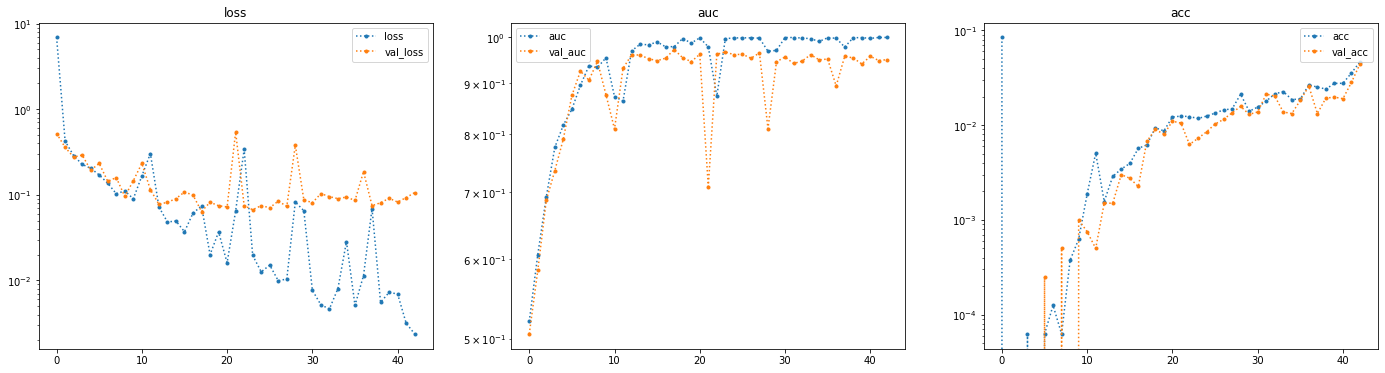

In [21]:
def plot_learning_curve(model):
    metrics = list(filter(lambda x: not x.startswith('val_'), model.history.history.keys()))
    print(metrics)
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(24, 6))
    
    for m, axi in zip(metrics, ax):
        axi.plot(model.history.epoch, model.history.history[m], ".:", label=m)
        axi.plot(model.history.epoch, model.history.history[f"val_{m}"], ".:", label=f"val_{m}")
        if m!='accuracy':
            axi.set_yscale('log')
        axi.set_title(m)
        axi.legend()

plot_learning_curve(model)

In [22]:
# model.evaluate_generator(train_gen, verbose=1)

In [23]:
y_test_pred = model.predict_generator(test_gen, verbose=1)

2/2 [==============================] - 2s 975ms/step


In [24]:
# y_test

In [25]:
cr = classification_report(np.argmax(y_test, 1), np.argmax(y_test_pred,1))
print(cr)

              precision    recall  f1-score   support

           0       0.46      0.86      0.60         7
           1       0.93      0.93      0.93        14
           2       1.00      0.60      0.75        10
           3       0.57      1.00      0.72        13
           4       1.00      1.00      1.00         4
           5       0.78      0.78      0.78         9
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         3
           8       0.89      0.89      0.89         9
           9       0.92      0.85      0.88        13
          10       0.58      0.78      0.67         9
          11       0.83      0.50      0.62        10
          12       0.80      0.57      0.67         7
          13       0.88      1.00      0.93        14
          15       1.00      0.57      0.73        14
          16       0.90      0.90      0.90        10
          17       0.92      0.85      0.88        13
          18       0.95    